In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

import torch.optim as optim
import torch.nn as nn

import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms


## Definicción de clases

In [2]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
n_classes = torch.tensor(len(classes))

## Preprocesamiento de los datos

In [3]:
def data_count(main_path = './data/Join'):
    counts = {}
    for root,dirs,files in os.walk(main_path):
        if files != [] and str(root.split('/')[-1]) in classes:
            counts[str(root.split('/')[-1])] = len(files)
    return counts

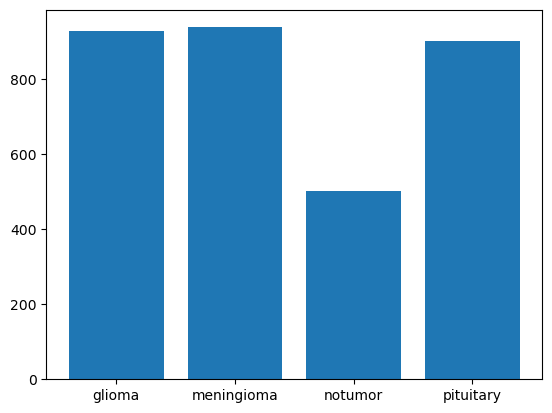

In [4]:
counts = data_count()

plt.bar(list(counts.keys()), list(counts.values()))
plt.show()

### Creamos una función que cree un diccionario con nuestra estructura de ficheros

Se realiza la separación en Train y Test

In [5]:
def get_data(main_path = './data/Join', split_percentage = 0.3):
    train_dict = {}
    test_dict = {}
    
    # Contamos cuantas
    #counts = data_count(main_path)
    
    # Recorremos el directorio donde están las imágenes
    for root, dir, files in os.walk(main_path):
        # Mientras queden archivos de las clases que queremos buscar
        if files != [] and str(root.split('/')[-1]) in ['glioma', 'meningioma', 'notumor', 'pituitary']:
            file_paths = [os.path.join(root, files[i]) for i in range(len(files))]
            
            # Reparto aleatorio para validar y entrenar
            test_idxs = np.random.randint(low=0, high=len(files), size=int(len(files)*split_percentage))
            
            train_idxs = list(set(range(0, len(files))) - set(test_idxs))
            
            # Rellenamos los diccionarios
            train_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in train_idxs]
            test_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in test_idxs]
  
    return train_dict, test_dict

In [6]:
train_dict, test_dict = get_data()

In [7]:
print('training data sizes : ', [len(l) for l in train_dict.values()])
print('testing data sizes : ', [len(l) for l in test_dict.values()])

training data sizes :  [689, 692, 368, 678]
testing data sizes :  [277, 281, 150, 270]


El diccionario tiene esta forma

In [8]:
print('train: ', train_dict['notumor'][0:3])
print('test: ', test_dict['notumor'][0:3])

train:  ['./data/Join/notumor/1.jpg', './data/Join/notumor/2.jpg', './data/Join/notumor/4.jpg']
test:  ['./data/Join/notumor/image(116).jpg', './data/Join/notumor/image_(99).jpg', './data/Join/notumor/image_(44).jpg']


In [9]:
test_dict.keys()

dict_keys(['glioma', 'meningioma', 'notumor', 'pituitary'])

### Ejemplo de las imágenes de train y test

In [10]:
def visualize(data_dict):
    """
    Función que muestra de forma aleatoria una foto de cada uno de los tipos de tumores
    """
    idx = np.random.randint(0, min(list([len(l) for l in data_dict.values()])))
    
    
    plt.figure(figsize=(20,6))
    
    plt.subplot(161)
    plt.imshow(cv2.imread(train_dict['glioma'][idx]).astype(int))
    plt.title('Glioma')
    
    plt.subplot(162)
    plt.imshow(cv2.imread(train_dict['meningioma'][idx]).astype(int))
    plt.title('Meningioma')
    
    plt.subplot(163)
    plt.imshow(cv2.imread(train_dict['notumor'][idx]).astype(int))
    plt.title('No Tumor')
    
    plt.subplot(164)
    plt.imshow(cv2.imread(train_dict['pituitary'][idx]).astype(int))
    plt.title('Pituitary')
    
    plt.show()

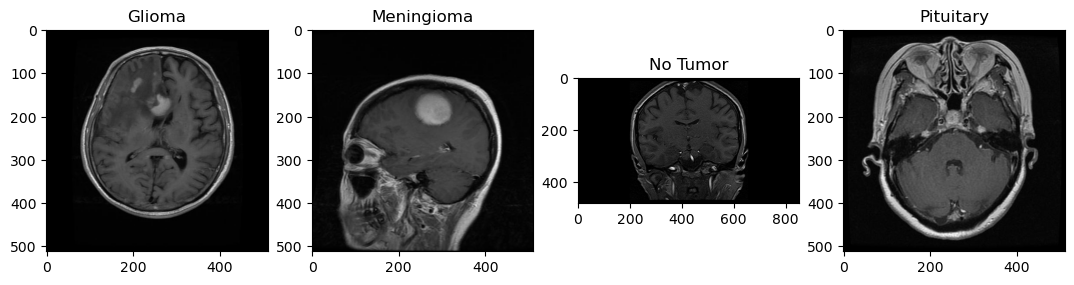

In [11]:
visualize(train_dict)

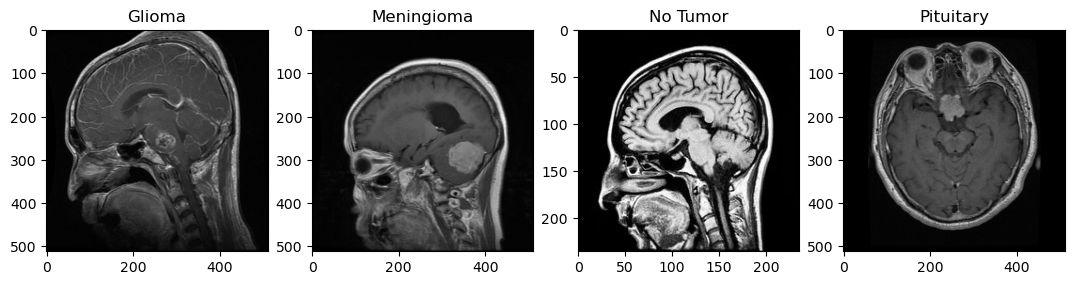

In [12]:
visualize(test_dict)

Como podemos ver no todas las fotos tienen el mismo tamaño ni forma, por lo que tenemos que definir una transformación para las imágenes

Creamos una clase que defina la operación de obtener una imagen del dataset

In [13]:
class MRIData(Dataset):
    """Brain Tumor images"""
    
    def __init__(self, data_dict, transform=None):
        """
        Args:
            data_dict (dict): diccionario con los tipos de tumor como clave. Contiene las rutas a las imágenes de cada tumor. 
        """
        self.data_dict = data_dict
        self.transform = transform
        
    # Redefinimos la forma de calcular el tamaño
    def __len__(self):
        return sum([len(l) for l in self.data_dict.values()])
    
    
    # Redefinimos la selección de los elementos para que se aplique la transfromación antes de seleccionarlos
    def __getitem__(self,idx):
            counts = [len(l) for l in self.data_dict.values()]
            sum_counts = list(np.cumsum(counts))
            sum_counts = [0] + sum_counts + [np.inf]

            for c,v in enumerate(sum_counts):
                if idx < v:
                    i = (idx - sum_counts[c-1]) - 1
                    break
            #print(c,i,idx)
            label = list(self.data_dict.keys())[c-1]
            img = Image.open(self.data_dict[str(label)][i]).convert('RGB')
            if self.transform:
                img = self.transform(img)

            return img, (F.one_hot(torch.tensor(classes.index(str(label))), num_classes=n_classes)).to(torch.float32)
        

Hay que ver si merece la pena esta parte. 
Como no hay 'demasiados' datos realizamos una transformación de los datos para aumentar la muestra

In [14]:
# Transformaciones que se le aplican a las imágenes antes de abrirlas

IMG_SIZE = 128
data_transform_train = transforms.Compose([transforms.ToTensor(),
                                         # Transformaciones aleatorias
                                         transforms.RandomVerticalFlip(),
                                         # transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                         transforms.RandomHorizontalFlip(),
                                         # transforms.ColorJitter(),

                                         # Resize para todas las fotos
                                         transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True)])

# En la parte de test no se realizan transformaciones para el Data Augmentation
data_transform_test = transforms.Compose([transforms.ToTensor(),
                                        # Resize para todas las fotos
                                        transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True)])

data_train = MRIData(train_dict, transform = data_transform_train)
data_test = MRIData(test_dict, transform = data_transform_test)

Total Number of training images :  2427
Total Number of validation images :  978


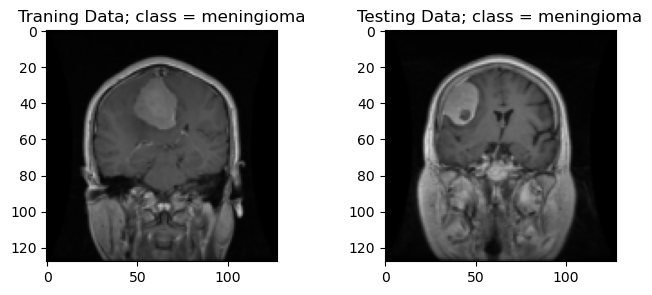

In [15]:
t_idx = np.random.randint(0,len(data_train))
v_idx = np.random.randint(0,len(data_test))

print("Total Number of training images : ", len(data_train))
print("Total Number of validation images : ", len(data_test))

t_img,t_label = data_train[t_idx]
v_img,v_label = data_test[v_idx]

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(t_img.numpy().transpose(1,2,0))
plt.title(f'Traning Data; class = {classes[torch.argmax(t_label).item()]}')
plt.subplot(122)
plt.imshow(v_img.numpy().transpose(1,2,0))
plt.title(f'Testing Data; class = {classes[torch.argmax(v_label).item()]}')
plt.show()


In [16]:
t_img[0].shape

torch.Size([128, 128])

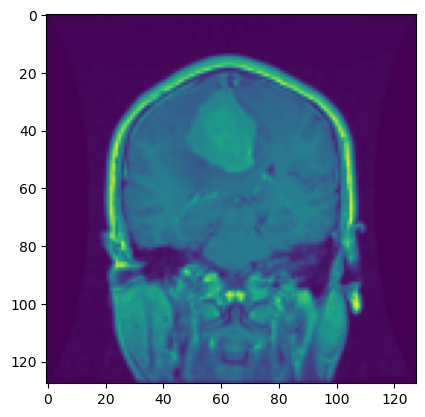

In [17]:
plt.imshow(t_img[2].numpy())

### Definición del Data Loader

In [18]:
from torchsummary import summary

In [19]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Convolucional 1 - [3 - 8]
            nn.Conv2d(3, 8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Convolucional 2 - [8 - 16]
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Convolucional 3 - [16 - 32]
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Convolucional 4 - [32 - 64]
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
        )
        
        self.classifier = nn.Sequential(
            # Red densax=input.view(-1, 3*128*128)
            nn.Linear(64*6*6, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 4) #capa de salida
        )

        
    def forward(self, x):
        
        x = self.features(x)      
        
        x = F.max_pool2d(x, 2)
        
        # APLANADO
        x = x.view(-1, 64*6*6)
        
        # RED DENSA
        x = self.classifier(x)
        
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activaions(self, x):
        return self.features(x)

In [20]:
net = myCNN()

In [21]:
net.features

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
)

In [22]:
input = torch.rand(3,128,128)
output = net(input) 

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [23]:
output.shape

torch.Size([1, 4])

In [24]:
summary(net, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 126, 126]             224
              ReLU-2          [-1, 8, 126, 126]               0
         MaxPool2d-3            [-1, 8, 63, 63]               0
            Conv2d-4           [-1, 16, 61, 61]           1,168
              ReLU-5           [-1, 16, 61, 61]               0
         MaxPool2d-6           [-1, 16, 30, 30]               0
            Conv2d-7           [-1, 32, 28, 28]           4,640
              ReLU-8           [-1, 32, 28, 28]               0
         MaxPool2d-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 64, 12, 12]          18,496
             ReLU-11           [-1, 64, 12, 12]               0
           Linear-12                  [-1, 512]       1,180,160
             ReLU-13                  [-1, 512]               0
           Linear-14                   

In [47]:
Epocas = 50

In [48]:
# trans = transforms.Compose([transforms.ToTensor(), transforms.Resize((255,255))]) #Transformador para el dataset

batch_size_train = 16
batch_size_test = 128

In [49]:
train_loader = torch.utils.data.DataLoader(
                 dataset=data_train,
                 batch_size=batch_size_train,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset= data_test,
                batch_size=batch_size_test,
                shuffle=False)

In [50]:
optimizador = torch.optim.RMSprop(lr=0.001, params = net.parameters()) 

In [51]:
loss_fn = torch.nn.CrossEntropyLoss()

In [52]:
print ('Trainning batch number: {}'.format(len(train_loader)))
print ('Testing batch number: {}'.format(len(test_loader)))

Trainning batch number: 152
Testing batch number: 8


In [53]:
accuracy_train = []
accuracy_test = []
len_data_train = len(data_train)
len_data_test = len(data_test)

In [54]:
from tqdm import tqdm

In [55]:
for epoch in range(Epocas):
    for xb, yb in tqdm(train_loader):
        optimizador.zero_grad()
        loss = loss_fn(net(xb), yb)
        loss.backward()
        optimizador.step()
    with torch.no_grad():
        aciertos_train = 0
        for xb, yb in tqdm(train_loader):
            aciertos_train += (net(xb).argmax(dim=1) == yb.argmax(dim=1)).sum()
        accuracy_train.append(aciertos_train/len_data_train)
        print("Epoch {}. Train accuracy : {}".format(epoch, accuracy_train[-1].item()))
        aciertos_test = 0
        for xb, yb in tqdm(test_loader):
            aciertos_test += (net(xb).argmax(dim=1) == yb.argmax(dim=1)).sum()
        accuracy_test.append(aciertos_test/len_data_test)
        print("\t\t\t\t\t\tTest accuracy :", accuracy_test[-1].item())

100%|█████████████████████████████████████████| 152/152 [00:27<00:00,  5.51it/s]


Epoch 0. Train accuracy : 0.9967037439346313


100%|█████████████████████████████████████████████| 8/8 [00:11<00:00,  1.40s/it]


						Test accuracy : 0.9263803958892822


100%|█████████████████████████████████████████| 152/152 [00:23<00:00,  6.44it/s]


Epoch 1. Train accuracy : 0.9962916970252991


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.13it/s]


						Test accuracy : 0.9325153231620789


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.28it/s]


Epoch 2. Train accuracy : 0.9880511164665222


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.15it/s]


						Test accuracy : 0.907975435256958


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.24it/s]


Epoch 3. Train accuracy : 0.995055615901947


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.12it/s]


						Test accuracy : 0.9233129024505615


100%|█████████████████████████████████████████| 152/152 [00:21<00:00,  6.95it/s]


Epoch 4. Train accuracy : 0.9958797097206116


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.21it/s]


						Test accuracy : 0.9243353605270386


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.36it/s]


Epoch 5. Train accuracy : 0.995055615901947


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.20it/s]


						Test accuracy : 0.9243353605270386


100%|█████████████████████████████████████████| 152/152 [00:19<00:00,  7.77it/s]


Epoch 6. Train accuracy : 0.9991759657859802


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.20it/s]


						Test accuracy : 0.9233129024505615


100%|█████████████████████████████████████████| 152/152 [00:21<00:00,  7.20it/s]


Epoch 7. Train accuracy : 0.995055615901947


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.20it/s]


						Test accuracy : 0.9202454090118408


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.31it/s]


Epoch 8. Train accuracy : 0.9954676628112793


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.20it/s]


						Test accuracy : 0.9233129024505615


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.49it/s]


Epoch 9. Train accuracy : 0.9942315816879272


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.23it/s]


						Test accuracy : 0.9049080014228821


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.26it/s]


Epoch 10. Train accuracy : 0.9991759657859802


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.11it/s]


						Test accuracy : 0.9355828166007996


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.54it/s]


Epoch 11. Train accuracy : 0.9995879530906677


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.13it/s]


						Test accuracy : 0.9263803958892822


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.59it/s]


Epoch 12. Train accuracy : 0.9991759657859802


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.21it/s]


						Test accuracy : 0.9376277923583984


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.53it/s]


Epoch 13. Train accuracy : 0.9905232787132263


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.20it/s]


						Test accuracy : 0.9130879640579224


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.43it/s]


Epoch 14. Train accuracy : 0.9991759657859802


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.24it/s]


						Test accuracy : 0.9243353605270386


100%|█████████████████████████████████████████| 152/152 [00:18<00:00,  8.08it/s]


Epoch 15. Train accuracy : 0.9995879530906677


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.18it/s]


						Test accuracy : 0.9274028539657593


100%|█████████████████████████████████████████| 152/152 [00:21<00:00,  7.06it/s]


Epoch 16. Train accuracy : 0.995055615901947


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.13it/s]


						Test accuracy : 0.9151329398155212


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.41it/s]


Epoch 17. Train accuracy : 0.9971157908439636


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.17it/s]


						Test accuracy : 0.9274028539657593


100%|█████████████████████████████████████████| 152/152 [00:19<00:00,  7.62it/s]


Epoch 18. Train accuracy : 0.9958797097206116


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.22it/s]


						Test accuracy : 0.9182004332542419


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.45it/s]


Epoch 19. Train accuracy : 0.998763918876648


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.25it/s]


						Test accuracy : 0.9314928650856018


100%|█████████████████████████████████████████| 152/152 [00:19<00:00,  7.79it/s]


Epoch 20. Train accuracy : 0.9975278377532959


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.17it/s]


						Test accuracy : 0.9325153231620789


100%|█████████████████████████████████████████| 152/152 [00:19<00:00,  7.63it/s]


Epoch 21. Train accuracy : 0.9975278377532959


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.20it/s]


						Test accuracy : 0.9314928650856018


100%|█████████████████████████████████████████| 152/152 [00:19<00:00,  7.68it/s]


Epoch 22. Train accuracy : 0.9958797097206116


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.17it/s]


						Test accuracy : 0.9263803958892822


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.47it/s]


Epoch 23. Train accuracy : 0.9958797097206116


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.24it/s]


						Test accuracy : 0.9141104221343994


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.51it/s]


Epoch 24. Train accuracy : 0.9929954409599304


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.20it/s]


						Test accuracy : 0.9059304594993591


100%|█████████████████████████████████████████| 152/152 [00:19<00:00,  7.73it/s]


Epoch 25. Train accuracy : 0.9991759657859802


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.22it/s]


						Test accuracy : 0.9406952857971191


100%|█████████████████████████████████████████| 152/152 [00:19<00:00,  7.60it/s]


Epoch 26. Train accuracy : 0.998763918876648


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.21it/s]


						Test accuracy : 0.9263803958892822


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.32it/s]


Epoch 27. Train accuracy : 0.9942315816879272


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.16it/s]


						Test accuracy : 0.9222903847694397


100%|█████████████████████████████████████████| 152/152 [00:18<00:00,  8.20it/s]


Epoch 28. Train accuracy : 0.9971157908439636


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.29it/s]


						Test accuracy : 0.9284253716468811


100%|█████████████████████████████████████████| 152/152 [00:24<00:00,  6.26it/s]


Epoch 29. Train accuracy : 0.9962916970252991


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.06s/it]


						Test accuracy : 0.9314928650856018


100%|█████████████████████████████████████████| 152/152 [00:27<00:00,  5.46it/s]


Epoch 30. Train accuracy : 0.998763918876648


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.07s/it]


						Test accuracy : 0.9366053342819214


100%|█████████████████████████████████████████| 152/152 [00:22<00:00,  6.63it/s]


Epoch 31. Train accuracy : 0.9995879530906677


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.17it/s]


						Test accuracy : 0.942740261554718


100%|█████████████████████████████████████████| 152/152 [00:23<00:00,  6.54it/s]


Epoch 32. Train accuracy : 0.9991759657859802


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.07s/it]


						Test accuracy : 0.941717803478241


100%|█████████████████████████████████████████| 152/152 [00:24<00:00,  6.10it/s]


Epoch 33. Train accuracy : 0.9864029884338379


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.08it/s]


						Test accuracy : 0.9100204706192017


100%|█████████████████████████████████████████| 152/152 [00:23<00:00,  6.48it/s]


Epoch 34. Train accuracy : 0.9967037439346313


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.01s/it]


						Test accuracy : 0.9366053342819214


100%|█████████████████████████████████████████| 152/152 [00:23<00:00,  6.59it/s]


Epoch 35. Train accuracy : 0.9979398250579834


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.03s/it]


						Test accuracy : 0.9345602989196777


100%|█████████████████████████████████████████| 152/152 [00:25<00:00,  5.86it/s]


Epoch 36. Train accuracy : 0.9991759657859802


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.12it/s]


						Test accuracy : 0.9335378408432007


100%|█████████████████████████████████████████| 152/152 [00:22<00:00,  6.86it/s]


Epoch 37. Train accuracy : 0.9983518719673157


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.24it/s]


						Test accuracy : 0.9345602989196777


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.50it/s]


Epoch 38. Train accuracy : 0.9934074878692627


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.25it/s]


						Test accuracy : 0.9274028539657593


100%|█████████████████████████████████████████| 152/152 [00:22<00:00,  6.84it/s]


Epoch 39. Train accuracy : 0.9909353256225586


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.10it/s]


						Test accuracy : 0.9182004332542419


100%|█████████████████████████████████████████| 152/152 [00:26<00:00,  5.83it/s]


Epoch 40. Train accuracy : 0.9991759657859802


100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.37it/s]


						Test accuracy : 0.942740261554718


100%|█████████████████████████████████████████| 152/152 [00:19<00:00,  7.68it/s]


Epoch 41. Train accuracy : 0.9995879530906677


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.27it/s]


						Test accuracy : 0.9253578782081604


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.60it/s]


Epoch 42. Train accuracy : 0.9942315816879272


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.22it/s]


						Test accuracy : 0.9233129024505615


100%|█████████████████████████████████████████| 152/152 [00:18<00:00,  8.44it/s]


Epoch 43. Train accuracy : 0.9983518719673157


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.32it/s]


						Test accuracy : 0.9274028539657593


100%|█████████████████████████████████████████| 152/152 [00:22<00:00,  6.73it/s]


Epoch 44. Train accuracy : 0.9991759657859802


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.17it/s]


						Test accuracy : 0.9314928650856018


100%|█████████████████████████████████████████| 152/152 [00:23<00:00,  6.40it/s]


Epoch 45. Train accuracy : 0.9995879530906677


100%|█████████████████████████████████████████████| 8/8 [00:09<00:00,  1.13s/it]


						Test accuracy : 0.9335378408432007


100%|█████████████████████████████████████████| 152/152 [00:22<00:00,  6.79it/s]


Epoch 46. Train accuracy : 0.9971157908439636


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.25it/s]


						Test accuracy : 0.9366053342819214


100%|█████████████████████████████████████████| 152/152 [00:21<00:00,  7.15it/s]


Epoch 47. Train accuracy : 0.9929954409599304


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


						Test accuracy : 0.9222903847694397


100%|█████████████████████████████████████████| 152/152 [00:20<00:00,  7.38it/s]


Epoch 48. Train accuracy : 0.9909353256225586


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.25it/s]


						Test accuracy : 0.9243353605270386


100%|█████████████████████████████████████████| 152/152 [00:21<00:00,  7.16it/s]


Epoch 49. Train accuracy : 0.9975278377532959


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.19it/s]

						Test accuracy : 0.9274028539657593


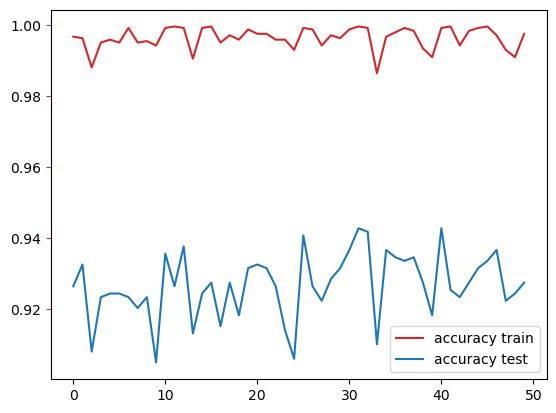

In [56]:
# Plot the Loss and Accuracy vs Epoch graph


color = 'tab:red'
plt.plot(accuracy_train, color=color, label = 'accuracy train')
plt.tick_params(axis='y', color=color)

color = 'tab:blue'
plt.plot( accuracy_test, color=color, label = 'accuracy test')
plt.legend()

## Guardamos los pesos de la red entrenada

In [45]:
#PATH = './pesos/weights.pt'
#torch.save(net.state_dict(), PATH)

## Try GradCAM


In [ ]:
# net.load_state_dict(torch.load('./pesos/weights.pt'))

In [57]:
def show_data(data_sample, label):
    plt.imshow(data_sample.numpy()[0][0], cmap = 'gray')
    plt.title('y = ' + classes[torch.argmax(label).item()])

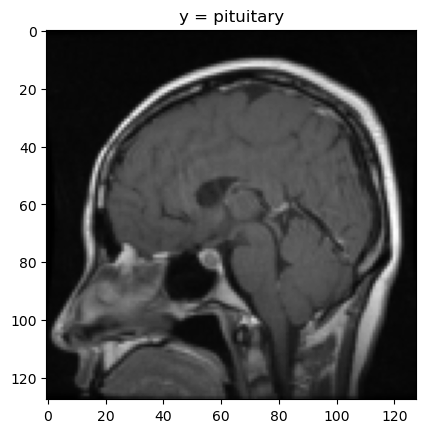

In [58]:
# Seleccionamos una imagen
valid_loader=DataLoader(data_test,batch_size=1,shuffle=True)

data,label=next(iter(valid_loader))
net.eval()
pred=net(data)
pred=torch.argmax(pred,dim=1)
# label=labels[pred.detach().cpu().item()]
show_data(data, label)

In [59]:
img_cam = net.features[:-1]
img_cam

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
)

In [60]:
def img2Cam(img):
    net.eval()
    logit = net(img)
    heatmaps = []
    activations = img_cam(img)
    pred = logit.max(-1)[-1]
    net.zero_grad()
    logit[0,pred].backward()
    pool_grad = net.features[-2].weight.grad.data.mean((1,2,3))
    
    for i in range(activations.shape[1]):
        activations[:,i,:,:]*=pool_grad[i]
        
    heatmap=torch.mean(activations,dim=0)[0].detach().cpu().numpy()
    return heatmap

In [61]:
def printGradCAM(img, label, net):
    heatmap=img2Cam(img)
    
    net.eval()
    pred = net(data)
    pred = torch.argmax(pred,dim=1)
    label = classes[torch.argmax(label).item()]
    label_pred = classes[pred.item()]
    
    SZ = img.shape[3]
    heatmap=255*(heatmap-heatmap.min())/(heatmap.max()-heatmap.min())
    heatmap=cv2.resize(heatmap,(SZ,SZ))
    img=img.squeeze(0)[0].numpy()

    plt.figure(figsize=(30,12))

    plt.subplot(161)
    plt.imshow(img,cmap="gray")
    plt.title('Imagen Original y = {}'.format(label))

    plt.subplot(162)
    plt.imshow(img,cmap="gray")
    plt.imshow(heatmap,cmap="jet",alpha=0.8)
    plt.title('y = {}'.format(label_pred))

    plt.show()

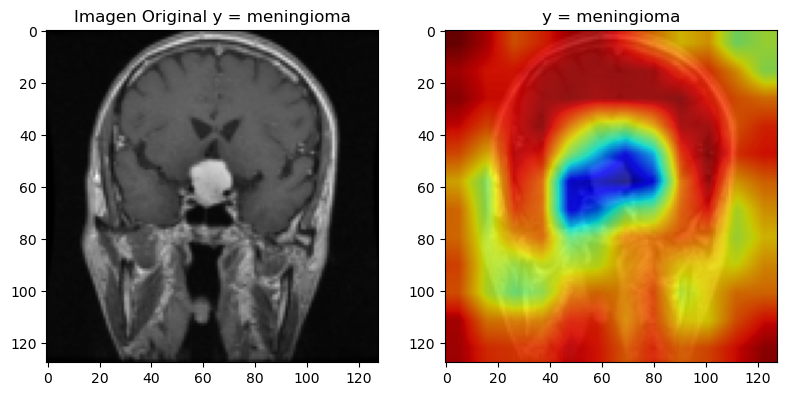

In [62]:
valid_loader=DataLoader(data_test,batch_size=1,shuffle=True)
data,label=next(iter(valid_loader))
printGradCAM(data, label, net)

## Imágenes extra

In [ ]:
# net.load_state_dict(torch.load('./pesos/weights.pt'))

In [63]:
def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name + '\nTamaño de los filtros: ' + str(W.shape[0:4]), fontsize=10) 
    plt.title(W.shape[1:4], fontsize = 5)
    plt.show()
    if(name != ""):
        namefig =  "./Images/kernel/" + name + ".png"
        fig.savefig(namefig)

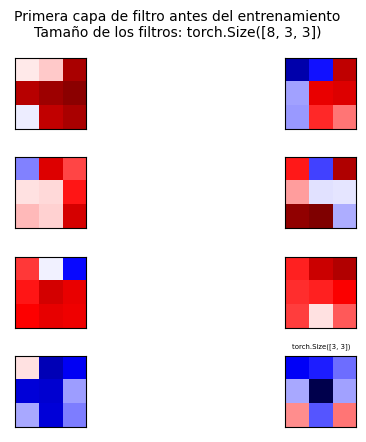

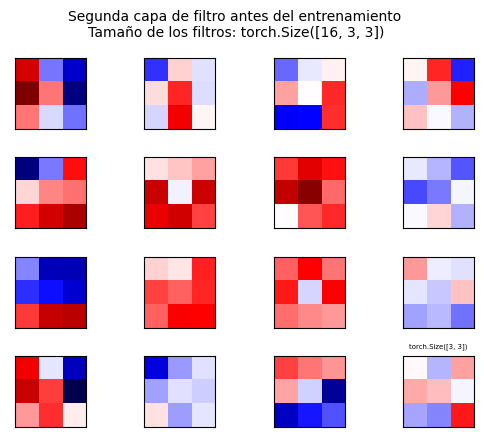

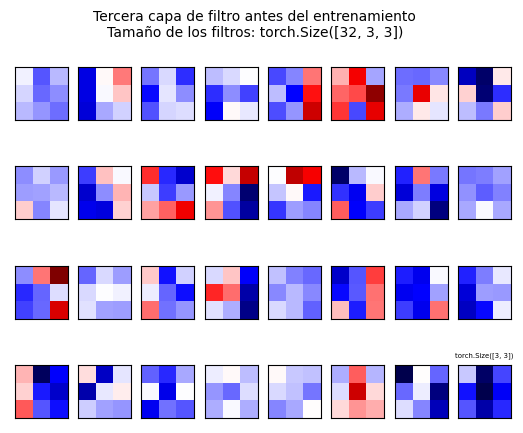

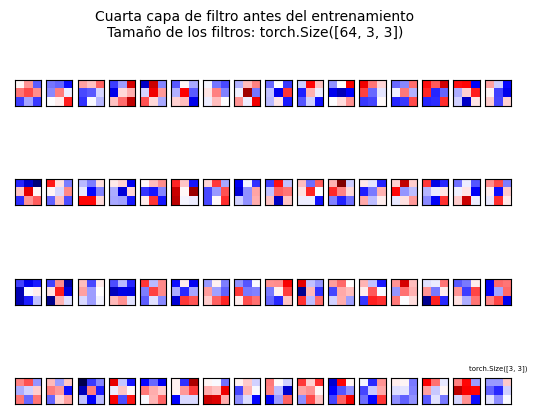

In [64]:
plot_parameters(net.state_dict()['features.0.weight'], number_rows=4, name="Primera capa de filtro antes del entrenamiento")
plot_parameters(net.state_dict()['features.3.weight'], number_rows=4, name="Segunda capa de filtro antes del entrenamiento ")
plot_parameters(net.state_dict()['features.6.weight'], number_rows=4, name="Tercera capa de filtro antes del entrenamiento")
plot_parameters(net.state_dict()['features.9.weight'], number_rows=4, name="Cuarta capa de filtro antes del entrenamiento")

In [65]:
def plot_activations(A, number_rows=1, name="", i=0, size = (20,20)):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    tam = A.shape[2]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.3)
    plt.figure(figsize= (40, 40))
    
    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
            
    
    
    fig.suptitle(name, fontsize=10)    
        
    plt.show()
    if(name != ""):
        namefig =  "./Images/" + name + ".png"
        fig.savefig(namefig)

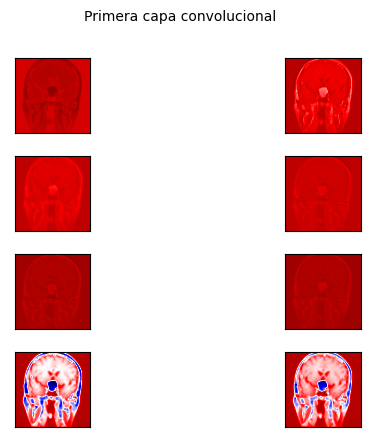

<Figure size 4000x4000 with 0 Axes>

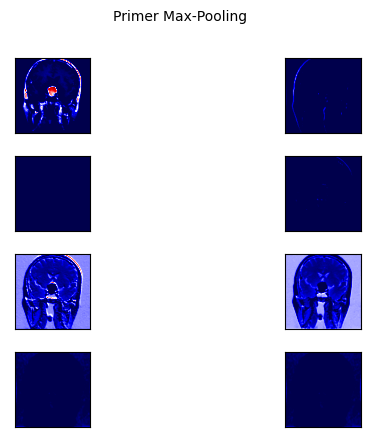

<Figure size 4000x4000 with 0 Axes>

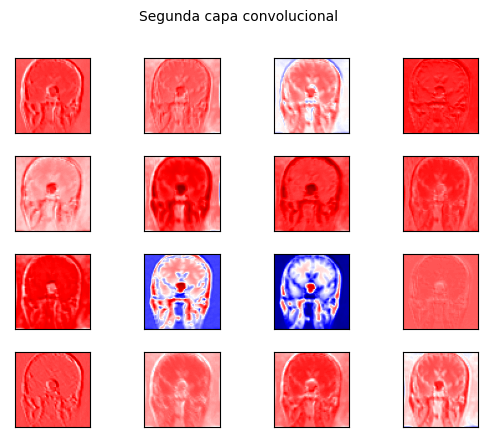

<Figure size 4000x4000 with 0 Axes>

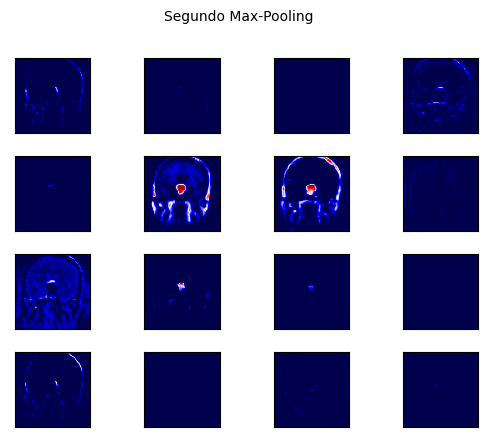

<Figure size 4000x4000 with 0 Axes>

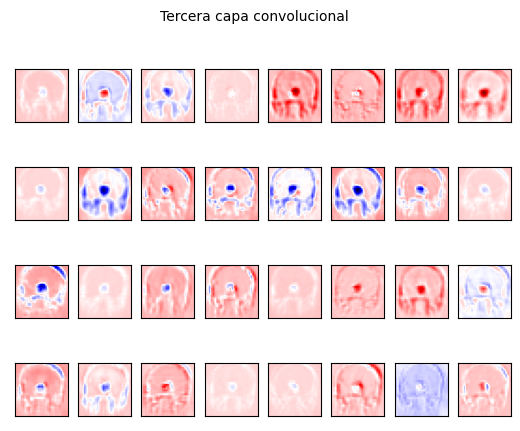

<Figure size 4000x4000 with 0 Axes>

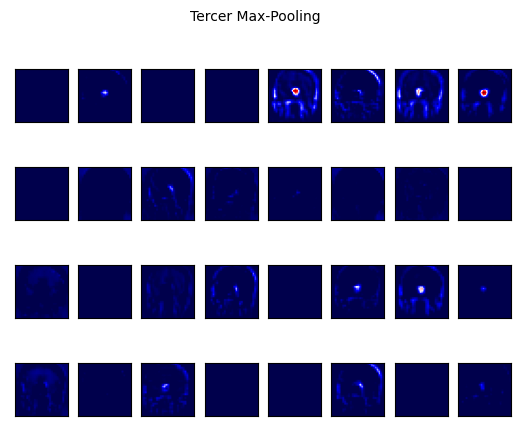

<Figure size 4000x4000 with 0 Axes>

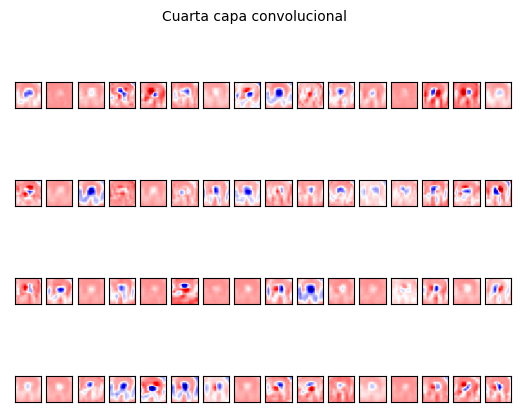

<Figure size 4000x4000 with 0 Axes>

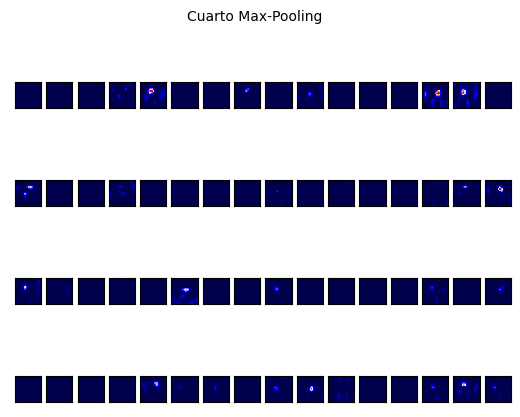

<Figure size 4000x4000 with 0 Axes>

In [66]:
out =  net.features[0](data)
plot_activations(out, number_rows=4, name = 'Primera capa convolucional')

out = net.features[:2](data)
plot_activations(out, number_rows=4, name = 'Primer Max-Pooling')


out = net.features[:4](data)
plot_activations(out, number_rows=4, name = 'Segunda capa convolucional')

out = net.features[:5](data)
plot_activations(out, number_rows=4, name = 'Segundo Max-Pooling')

out = net.features[:7](data)
plot_activations(out, number_rows=4, name = 'Tercera capa convolucional')

out = net.features[:8](data)
plot_activations(out, number_rows=4, name = 'Tercer Max-Pooling')

out = net.features[:10](data)
plot_activations(out, number_rows=4, name = 'Cuarta capa convolucional', size = (40, 80))

out = net.features[:12](data)
plot_activations(out, number_rows=4, name = 'Cuarto Max-Pooling')

### Representación 3D

In [67]:
def plot_parameters3d(matriz, ncapa = ''):
    # Normalizar la matriz entre 0 y 1
    min_val = np.min(matriz)
    max_val = np.max(matriz)
    matriz_norm = (matriz - min_val) / (max_val - min_val)

    # Crear figura
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Crear malla de cubos
    for layer in range(matriz_norm.shape[0]):
        for x in range(matriz_norm.shape[1]):
            for y in range(matriz_norm.shape[2]):
                # Obtener el color normalizado de cada cubo de la matriz
                color = matriz_norm[layer, x, y]

                # Definir coordenadas del cubo
                x_coords = [x, x + 1, x + 1, x, x, x]
                y_coords = [y, y, y + 1, y + 1, y, y]
                z_coords = [layer, layer, layer, layer, layer, layer]

                # Generar cubo con color mapeado
                ax.plot_trisurf(x_coords, y_coords, z_coords, color=plt.cm.seismic(color))

    # Configurar ejes
    ax.set_xlim(0, matriz_norm.shape[1])
    ax.set_ylim(0, matriz_norm.shape[2])
    ax.set_zlim(0, matriz_norm.shape[0] - 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Rotar la figura
    ax.view_init(elev=30, azim=45)
    
    
    fig.suptitle('Representación tridimensional\n de un filtro en la capa ' + ncapa, fontsize=20)    

    # Mostrar figura
    plt.show()
    
    if(ncapa != ""):
        namefig =  "./Images/3d/Filtro3dCapa_" + ncapa + ".png"
        fig.savefig(namefig)

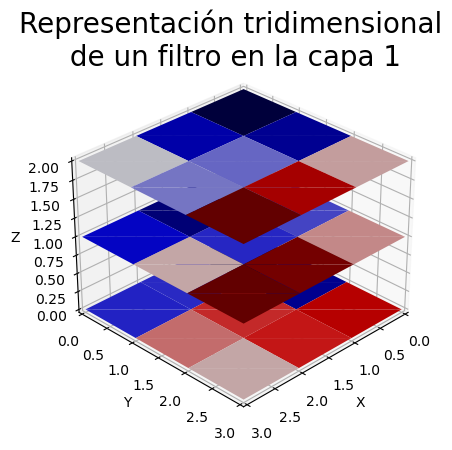

In [69]:
kern = net.state_dict()['features.0.weight'].detach().numpy()

kern1 = kern[1,:,:,:]
plot_parameters3d(kern1, ncapa = '1')

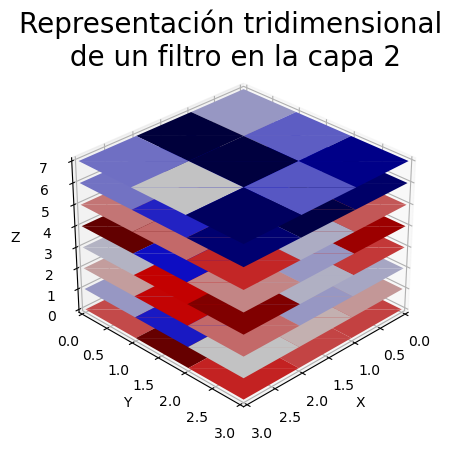

In [70]:
kern = net.state_dict()['features.3.weight'].detach().numpy()

kern2 = kern[1,:,:,:]

plot_parameters3d(kern2, ncapa='2')

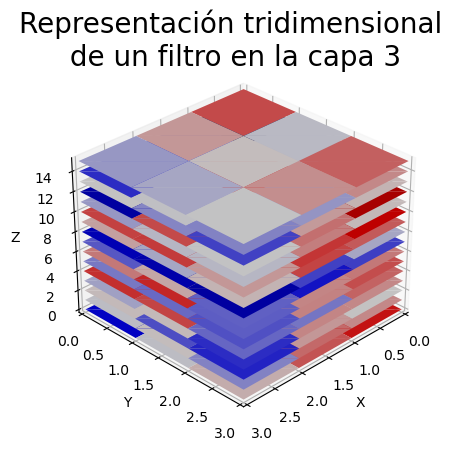

In [71]:
kern = net.state_dict()['features.6.weight'].detach().numpy()

kern3 = kern[1,:,:,:]

plot_parameters3d(kern3, ncapa='3')

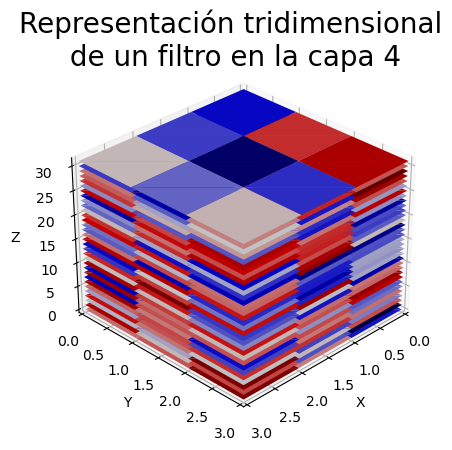

In [72]:
kern = net.state_dict()['features.9.weight'].detach().numpy()

kern4 = kern[1,:,:,:]

plot_parameters3d(kern4, ncapa='4')